In [0]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

%matplotlib inline
pd.set_option('display.max_colwidth', 300)

In [0]:
from google.colab import files
uploaded = files.upload()

In [0]:

meta = pd.read_csv("movie.metadata.tsv", sep = '\t', header = None)
meta.head()

,0,1,2,3,4,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}"
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey Mystery,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0"": ""Drama"", ""/m/0hj3n01"": ""Crime Drama""}"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama""}"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic thriller"", ""/m/09blyk"": ""Psychological thriller""}"
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [0]:
# rename columns
meta.columns = ["movie_id",1,"movie_name",3,4,5,6,7,"genre"]

In [0]:
from google.colab import files
uploaded = files.upload()

MessageError: ignored

In [0]:
plots = []

with open("plot_summaries.txt", 'r') as f:
       reader = csv.reader(f, dialect='excel-tab') 
       for row in tqdm(reader):
            plots.append(row)

42303it [00:01, 38833.17it/s]


In [0]:
movie_id = []
plot = []

# extract movie Ids and plot summaries
for i in tqdm(plots):
  movie_id.append(i[0])
  plot.append(i[1])

# create dataframe
movies = pd.DataFrame({'movie_id': movie_id, 'plot': plot})

100%|██████████| 42303/42303 [00:00<00:00, 1187278.46it/s]


In [0]:
movies.head()

,movie_id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all."
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole..."
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e..."
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo..."
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r..."


In [0]:
# change datatype of 'movie_id'
meta['movie_id'] = meta['movie_id'].astype(str)

# merge meta with movies
movies = pd.merge(movies, meta[['movie_id', 'movie_name', 'genre']], on = 'movie_id')

movies.head()

,movie_id,plot,movie_name,genre
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World cinema""}"
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama""}"
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...",Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama"", ""/m/01chg"": ""Bollywood""}"
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""Comedy""}"
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r...",A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama"", ""/m/01f9r0"": ""Docudrama"", ""/m/03q4nz"": ""World cinema"", ""/m/05bh16v"": ""Courtroom Drama""}"


In [0]:
movies['genre'][0]

'{"/m/07s9rl0": "Drama", "/m/03q4nz": "World cinema"}'

In [0]:
type(json.loads(movies['genre'][0]))

dict

In [0]:
json.loads(movies['genre'][0]).values()

dict_values(['Drama', 'World cinema'])

In [0]:
# an empty list
genres = [] 

# extract genres
for i in movies['genre']: 
  genres.append(list(json.loads(i).values())) 

# add to 'movies' dataframe  
movies['genre_new'] = genres

In [0]:
# remove samples with 0 genre tags
movies_new = movies[~(movies['genre_new'].str.len() == 0)]

In [0]:
movies_new.shape, movies.shape

((41793, 5), (42204, 5))

In [0]:
# get all genre tags in a list
all_genres = sum(genres,[])
len(set(all_genres))

363

In [0]:
all_genres = nltk.FreqDist(all_genres) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

In [0]:
# g = all_genres_df.nlargest(columns="Count", n = 50) 
# # plt.figure(figsize=(12,15)) 
# ax = sns.barplot(data=g, x= "Count", y = "Genre") 
# ax.set(ylabel = 'Count') 
# plt.show()

In [0]:
# function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

In [0]:
movies_new['clean_plot'] = movies_new['plot'].apply(lambda x: clean_text(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


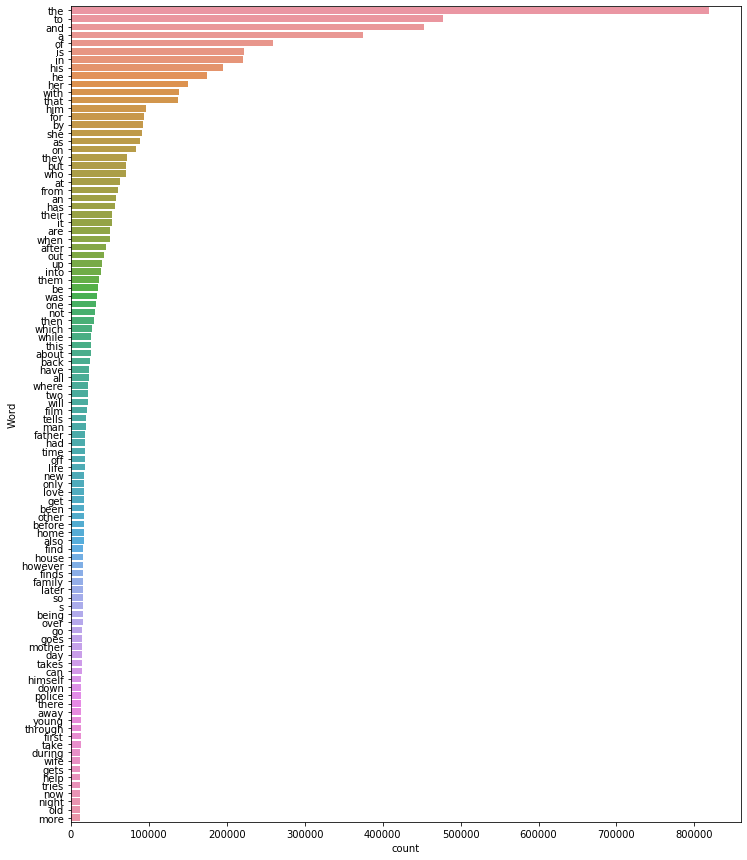

In [0]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 100 most frequent words 
freq_words(movies_new['clean_plot'], 100)

In [0]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

movies_new['clean_plot'] = movies_new['clean_plot'].apply(lambda x: remove_stopwords(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


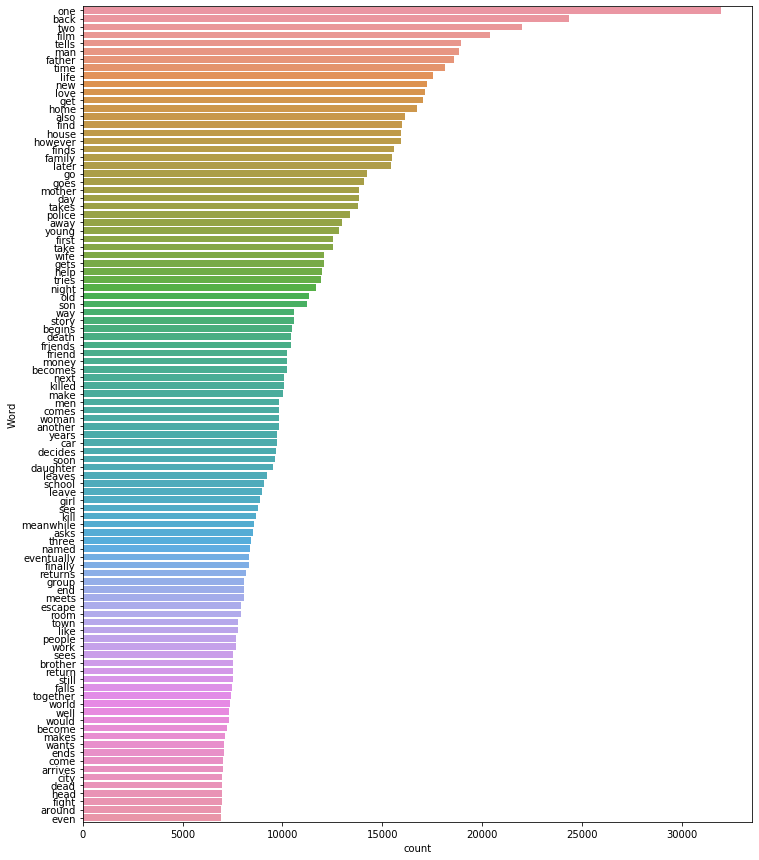

In [0]:
freq_words(movies_new['clean_plot'], 100)

In [0]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(movies_new['genre_new'])

# transform target variable
y = multilabel_binarizer.transform(movies_new['genre_new'])

In [0]:
# pip install glove_python

     |████████████████████████████████| 266kB 2.8MB/s 
  Created wheel for glove-python: filename=glove_python-0.1.0-cp36-cp36m-linux_x86_64.whl size=700329 sha256=064cd6e6cd8dfea9729b84cc8865155080a518a59f89662c0b14b0f8b56f2eff
  Stored in directory: /root/.cache/pip/wheels/88/4b/6d/10c0d2ad32c9d9d68beec9694a6f0b6e83ab1662a90a089a4b
Successfully built glove-python


In [0]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

In [0]:
# split dataset into training and validation set
xtrain, xval, ytrain, yval = train_test_split(movies_new['clean_plot'], y, test_size=0.2, random_state=9)

In [0]:
#create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)


# glove = Glove(no_components=5, learning_rate=0.05)
 
# xtrain_tfidf=glove.fit(xtrain)
# xval_tfidf = glove.transform(xval)



In [0]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

In [0]:
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import tree
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import f1_score

In [0]:
dt = DecisionTreeClassifier(criterion = 'gini', min_samples_leaf=1)
dt_gini = OneVsRestClassifier(dt)
dt_gini.fit(xtrain_tfidf,ytrain)
y_pred_valid=dt_gini.predict(xval_tfidf)
a=dt_gini.score(xtrain_tfidf,ytrain)  
#t=.3
# b=median_absolute_error(yval, y_pred_train)
# c=mean_absolute_error(yval, y_pred_train)
# d=roc_auc_score(yval,y_pred_train )
e=accuracy_score(yval,y_pred_valid )
f=f1_score(yval, y_pred_valid, average="micro")
# y_pred_prob = dt_gini.predict_proba(xval_tfidf)
# y_pred_new = (y_pred_prob >= t).astype(int)
# g=f1_score(yval, y_pred_new, average="micro")

# value={a,b,c,d,e,f,g}
# v=pd.DataFrame(value)

KeyboardInterrupt: ignored

In [0]:
R= RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
RF= OneVsRestClassifier(R)
RF.fit(xtrain_tfidf,ytrain)
y_pred_valid=RF.predict(xval_tfidf)
a=RF.score(xtrain_tfidf,ytrain) 
e=accuracy_score(yval,y_pred_valid )
g=f1_score(yval, y_pred_valid, average="micro")
# value={a,b,c,d,e,f}
# v=pd.DataFrame(value)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [0]:
y_pred_valid[3]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [0]:
S=SVC(C=1, kernel='rbf')
SVM= OneVsRestClassifier(S)
SVM.fit(xtrain_tfidf,ytrain)
y_pred_valid=SVM.predict(xval_tfidf)
a=SVM.score(xtrain_tfidf,ytrain) 
e=accuracy_score(yval,y_pred_valid )
h=f1_score(yval, y_pred_valid, average="micro")
# value={a,b,c,d,e,f}
# v=pd.DataFrame(value)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default 

In [0]:
l=LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)
lda= OneVsRestClassifier(l)

In [0]:
lda.fit(xtrain_tfidf.toarray(),ytrain)

In [0]:
y_pred_valid=lda.predict(xval_tfidf)
# a=lda.score(xtrain_tfidf,ytrain) 
# e=accuracy_score(yval,y_pred_valid )

In [0]:
f1_score(yval, y_pred_valid, average="micro")

In [0]:
from sklearn.naive_bayes import GaussianNB
N= GaussianNB()
NB= OneVsRestClassifier(N)
NB.fit(xtrain_tfidf,ytrain)
y_pred_valid=NB.predict(xval_tfidf)
a=NB.score(xtrain_tfidf,ytrain) 
e=accuracy_score(yval,y_pred_valid )
j=f1_score(yval, y_pred_valid, average="micro")
# value={a,b,c,d,e,f}
# v=pd.DataFrame(value)

In [0]:
lr = LogisticRegression(penalty='l2',random_state=0, solver='lbfgs',multi_class='multinomial')
clf = OneVsRestClassifier(lr)

In [0]:
# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

/usr/local/lib/python3.6/dist-packages/sklearn/multiclass.py:76: UserWarning: Label not 48 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/multiclass.py:

In [0]:
# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

In [0]:
y_pred[3]

In [0]:
multilabel_binarizer.inverse_transform(y_pred)[3]

In [0]:
# evaluate performance
f1_score(yval, y_pred, average="micro")

In [0]:
# predict probabilities
y_pred_prob = clf.predict_proba(xval_tfidf)

In [0]:
t = 0.3 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

In [0]:
# evaluate performance
f1_score(yval, y_pred_new, average="micro")

0.45120515034937586

In [0]:
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

In [0]:
for i in range(5): 
  k = xval.sample(1).index[0] 
  print("Movie: ", movies_new['movie_name'][k], "\nPredicted genre: ", infer_tags(xval[k])), print("Actual genre: ",movies_new['genre_new'][k], "\n")


Movie:  After the Fox 
Predicted genre:  [()]
Actual genre:  ['Crime Fiction', 'Crime Comedy', 'Comedy'] 

Movie:  Sail a Crooked Ship 
Predicted genre:  [('Comedy',)]
Actual genre:  ['Crime Fiction', 'Comedy'] 

Movie:  Web of Fear 
Predicted genre:  [('Thriller',)]
Actual genre:  ['Thriller', 'Crime Thriller'] 

Movie:  Forbidden Lie$ 
Predicted genre:  [('Drama',)]
Actual genre:  ['Culture & Society', 'Biography', 'Language & Literature', 'World cinema', 'Documentary'] 

Movie:  Dr. Pasupathy 
Predicted genre:  [('Drama',)]
Actual genre:  ['Comedy film'] 

